# Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import pandas as pd
import matplotlib.pylab as plt

from astropy.io import fits
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as units

from uncertainties import ufloat
from collections import Counter

from functions import *

%matplotlib inline

## Parameters

### Base name of matched catalogue
Name without file extension '.csv' of the matched catalogue containing magnitudes and spectra.

In [3]:
# Stephen's UNIONS+SDSS
#base_name = 'unions.ugriz'

# Stephen's UNIONS+DEEP3
base_name = 'w3.ugriz.spec'

# Stephen's UNIONS MK-matched with SDSS
#base_name = 'unions.ugriz2'

# Shear Data Club catalogue from Xavier, W3+Deep23 (2021)
base_name = 'CFIS_matched_alldeep_catalog_lephare_RIZGY'

### Input file columns

#### Photometric bands

In [4]:
#bands = ['u', 'g', 'r', 'i', 'z']

bands = ['MAG_AUTO_Z', 'MAG_AUTO_Y', 'MAG_AUTO_R', 'MAG_AUTO_I', 'MAG_AUTO_G,']

In [5]:
#### Spectroscopic redshift
col_zs = 'Z_SPEC'

### Survey name
Specify a name for the survey. Result files will be stored in a corresponding subdirectory.

In [6]:
#survey = 'UNIONS_800_MKmatch_SDSS'

survey = 'Xavier_W3_Deep23'

### Machine-learning parameters

In [7]:
# Action on missing data
preprocessing = 'drop'

# number of samples for cross-validation, default=4
cv = 4

In [8]:
# Set paths

base_path = '.'

# Input file path
path_to_csv = f'{base_path}/{base_name}.csv'

# Output paths
output_name = 'out'

temp_path = 'temp/'

In [9]:
# Clean up and generate subdirectories
GenFiles = GenerateFiles(survey, bands, temp_path, output_name, base_path)
GenFiles.clean_temp_directories()
for f in [False, True]:
    GenFiles.make_directories(output=f)

Successfully removed the directory temp/Xavier_W3_Deep23/d2d/ 
Successfully removed the directory temp/Xavier_W3_Deep23/matched/ 
Successfully removed the directory temp/Xavier_W3_Deep23/unmatched/ 
Successfully removed the directory temp/Xavier_W3_Deep23/vignet/ 
Successfully removed the directory temp/Xavier_W3_Deep23/redshift/ 
Successfully removed the directory temp/Xavier_W3_Deep23/spectral_surveys/ 
Successfully created the directory temp/Xavier_W3_Deep23/vignet/MAG_AUTO_Z 
Successfully created the directory temp/Xavier_W3_Deep23/vignet/MAG_AUTO_Y 
Successfully created the directory temp/Xavier_W3_Deep23/vignet/MAG_AUTO_R 
Successfully created the directory temp/Xavier_W3_Deep23/vignet/MAG_AUTO_I 
Successfully created the directory temp/Xavier_W3_Deep23/vignet/MAG_AUTO_G, 
Successfully created the directory temp/Xavier_W3_Deep23/vignet/array 


In [10]:
# Set up ML class
ML = LearningAlgorithms(
    survey=survey,
    bands=bands,
    path_to_csv=path_to_csv,
    output_name=output_name,
    output_path=base_path,
    cv=cv,
    preprocessing=preprocessing,
    n_jobs=1
)

In [13]:
df_matched = pd.read_csv(path_to_csv)

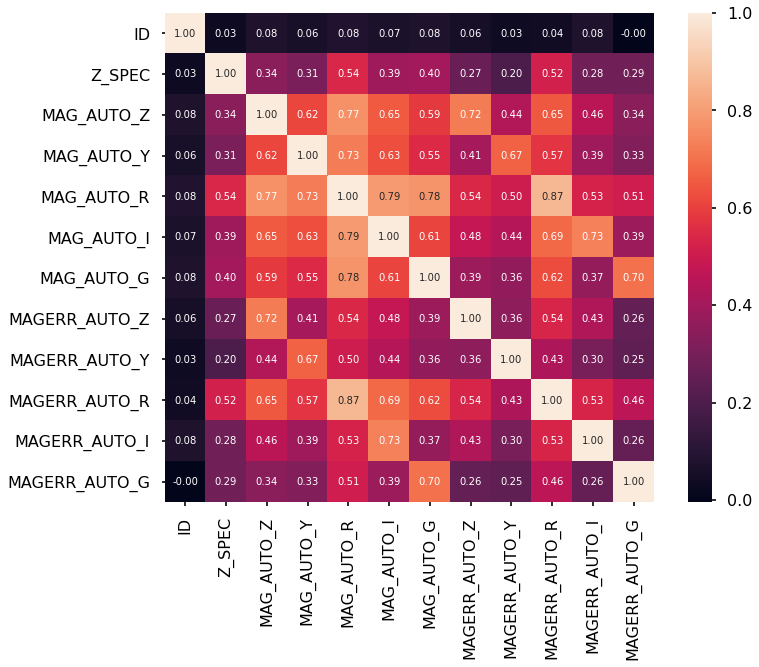

In [14]:
# Plot correlation matrix
ML.plot_corrmat(df_matched)

In [15]:
# Remove unwanted columns
cols_to_remove = []
for col in df_matched.columns:
    if (
        col not in bands
        and col != col_zs
    ):
        cols_to_remove.append(col)
df_matched.drop(columns=cols_to_remove, inplace=True)

In [16]:
n_cols = len(df_matched.columns)

# Move redshift column to the end if necessary
if not df_matched.columns[n_cols-1] == col_zs:
    zs = df_matched.pop(col_zs)
    df_matched.insert(n_cols-1, col_zs, zs)

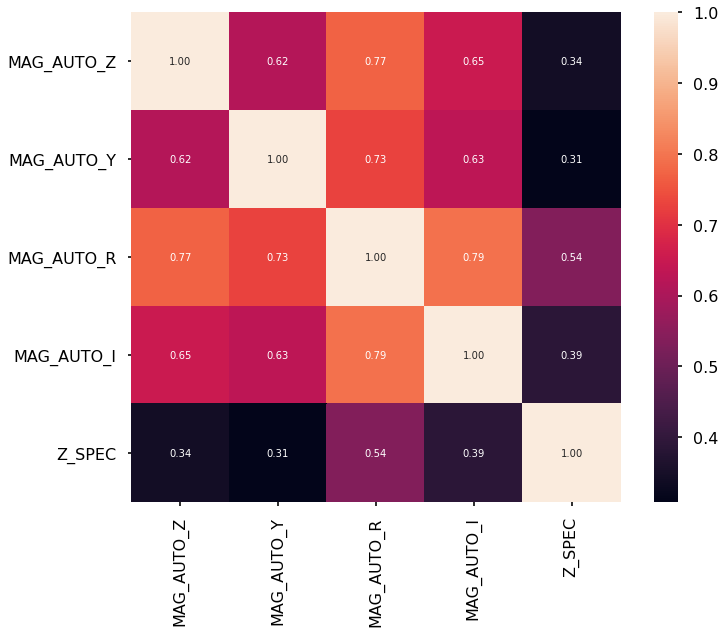

In [17]:
# Plot correlation matrix of preprocessed data
ML.plot_corrmat(df_matched)

In [18]:
# Set up ML algorithms

algs = {'RF': RandomForest}
weights = None
method = {}

for alg_name in algs:
    best_score = 1
    alg = algs[alg_name]
    method[alg_name] = alg(
        survey=survey,
        bands=bands,
        output_name=output_name,
        temp_path=temp_path,
        dataframe=df_matched,
        path_to_csv=None,
        validation_set=False,
        output_path=base_path,
        sample_weight=weights,
        cv=cv,
        preprocessing=preprocessing,
        n_jobs=1
    )

In [27]:
# Run ML algorithms
score = {}
predict = {}
y_pred_dict = {}
y_test_dict = {}

for alg_name in algs:

    # Get score from cross-validation
    score[alg_name] = method[alg_name].score(df_matched)

    # Get model data
    _, y_pred, y_test = method[alg_name].model()
    y_pred_dict[alg_name] = y_pred

    y_test_dict[alg_name] = y_test

100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


In [21]:
predict['RF'](method['RF'].X_test)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [22]:
# Print sigma and eta with error bars, as computed from cross-validation
for alg_name in algs:
    sigma = ufloat(score[alg_name][0], score[alg_name][1])
    eta = ufloat(score[alg_name][2], score[alg_name][3])
    print(
        f'{alg_name}: sigma={sigma:.3gP}, '
        + f'eta={eta:.3gP}',
        end='\r'
    )

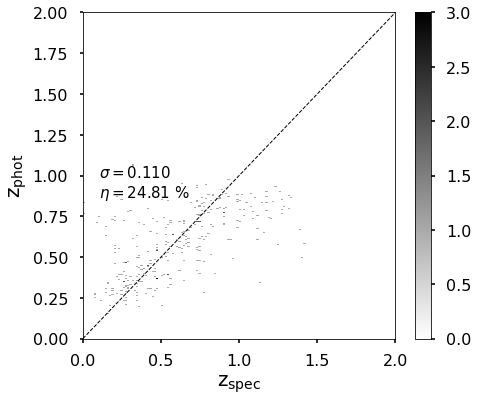

In [23]:
# Plot
lim = 2
for alg_name in algs:
    method[alg_name].plot_zphot_zspec(y_pred_dict[alg_name], y_test_dict[alg_name], alg_name, lim, nbins=200)

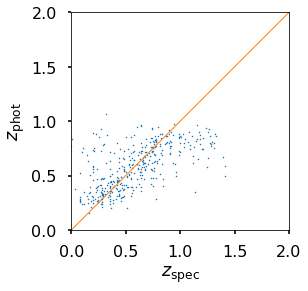

In [25]:
fig, (ax) = plt.subplots(1, 1)

ax.plot(y_test_dict['RF'], y_pred_dict['RF'], '.', markersize=3)
ax.plot([0, lim], [0, lim], '-', linewidth=1)
ax.set_ylim(0, lim)
ax.set_xlim(0, lim)
ax.set_xlabel(r'$z_{\rm spec}$')
ax.set_ylabel(r'$z_{\rm phot}$')
ax.set_aspect('equal')
_ = plt.savefig(f'{base_path}/output/{survey}/{output_name}/figures/out_RF_zphot_zspec_2.pdf')

In [42]:
regressor = RandomForestRegressor(**method['RF'].params)

In [45]:
regressor.predict(method['RF'].X_test)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [41]:
len(method['RF'].model())
#print(method['RF'].y_test)

3

In [35]:
help(train_test_split)ikm

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, **options)
    Split arrays or matrices into random train and test subsets
    
    Quick utility that wraps input validation and
    ``next(ShuffleSplit().split(X, y))`` and application to input data
    into a single call for splitting (and optionally subsampling) data in a
    oneliner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to the
        complement of the train size. If ``train_size`` is also Non